In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data_path = '../data/age_binned/'
model_path = '../../../modeling/v5/model/'


In [2]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))

def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [17]:
def predict_df(path, nbootstrap=1):

    df = pd.read_csv(path)
    
    ps = []
    for i in range(nbootstrap):
    
        if i==0:
            data = df.value.values
        else:
            data = np.random.choice(df.value.values, len(df.value.values), replace=True)

        # standardize
        mean = data.mean()
        std = data.std()
        data = (data - mean)/std

        # feature extraction
        features = extract_features(data)

        # predict
        p = model.predict(features[np.newaxis,...], verbose=0)
        p = scalery.inverse_transform(p)[0]
#         p = p[[1, -3]] # retrieve the elements corresponding to 0.025 and 0.975 quantiles
        # convert back to original scale
        p[:-1] *= std
        p[:-1] += mean
        ps.append(p)
    
    ps = np.array(ps)
    
    return ps[0]
    

In [36]:
from scipy.interpolate import interp1d

def plot_pdf_from_quantiles(values, weight, num_points=1000):
    """
    Plots the PDF of a distribution from given quantiles and corresponding values.
    
    Parameters:
    - quantiles: array-like, quantile values (e.g., [0.05, 0.25, 0.50, 0.75, 0.95])
    - values: array-like, corresponding values for the quantiles (e.g., [-1.64, -0.67, 0.0, 0.67, 1.64])
    - num_points: int, number of points to use for plotting (default: 1000)
    """
    
    quantiles = [0.01, 0.025, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.99]

    # Ensure input is numpy array
    quantiles = np.array(quantiles)
    values = np.array(values)
    
    # Create an interpolation of the CDF
    cdf = interp1d(values, quantiles, kind='cubic', fill_value="extrapolate")
    
    # Generate a range of values for plotting
    x = np.linspace(min(values), max(values), num_points)
    y_cdf = cdf(x)
        
    # Estimate the PDF by differentiating the CDF
    pdf = np.gradient(y_cdf, x)
    
    # Plot the PDF
    plt.plot(x, pdf*weight, label='Estimated PDF')


In [37]:
path = '../data/age_binned/data_85.csv'
data = pd.read_csv(path).value
result = predict_df(path)


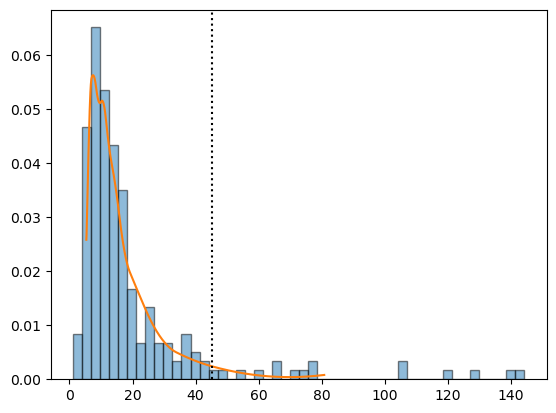

In [39]:
plt.hist(data, 50, edgecolor='k', density=True, alpha=0.5);
plot_pdf_from_quantiles(result[:-1], result[-1])
plt.axvline(result[-4], c='k', linestyle=':')
